# Utils

In [5]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
from typing import Tuple

In [135]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    # plot map of global data with central longitude 180
    # Uncomment for reds
    # cmap = matplotlib.cm.get_cmap(cmap)
    # norm = matplotlib.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
    # cmap = [cmap(norm(l)) for l in levels]
    # cmap[0] = (1, 1, 1, 1) # Set first element to white
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        # colors=cmap, # uncomment for reds
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if contours is not None:
        ax.contour(
            lon, lat, contours,
            transform=ccrs.PlateCarree(),
            colors="black",
            levels=[-1, -.9, -.8, -.7, -.6, -.5, -.4] # Contours for -1 to 1 correlations
            # levels=[-300, -200, -100, 0, 100, 125, 150, 175, 200] # Contours for PSL
        )
    if pr is not None:
        ax.contour(
            lon, lat, pr,
            transform=ccrs.PlateCarree(),
            # cmap="magenta",
            colors="magenta",
            # levels=[-2, -1.2, .4, .6],
            levels=[-6, 6],
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        # q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        # Scale for Pr wind maps
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.15, .25, str(.25) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # # East Pacific South America
    # bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")
    # Southern ITCZ 
    # bound_region(ax, lons=(-130, -80), lats=(-20, 0), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    # cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    


In [29]:
min_year, max_year = 1, 30
months = np.arange(1, 12)
years = np.arange(min_year*12, (max_year+1)*12, 12)

def calculate_coupling_depending_on_time(
    so_ssts = None, 
    ept_ssts = None, 
    models = None,
):
    time = [*months, *years]
    reg_coeffs, rvalues, pvalues, variance_so, variance_ept = [], [], [], [], []
    for year in time:
        ts_so_ssts = get_rolling_timeseries(so_ssts, window=year, step=12, gradient=False)
        ts_ept_ssts = get_rolling_timeseries(ept_ssts, window=year, step=12, gradient=False)

        variance_ept.append(ts_ept_ssts.std(dim="time"))
        variance_so.append(ts_so_ssts.std(dim="time"))
        rvalues.append(xscore.pearson_r(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['years', 'model'], np.array(reg_coeffs))}, coords={'model': models, 'years': time})
    rvalues = xr.Dataset({'rvalues': (['years', 'model'], np.array(rvalues))}, coords={'model': models, 'years': time})
    pvalues = xr.Dataset({'pvalues': (['years', 'model'], np.array(pvalues))}, coords={'model': models, 'years': time})
    variance_so = xr.Dataset({'variance_so': (['years', 'model'], np.array(variance_so))}, coords={'model': models, 'years': time})
    variance_ept = xr.Dataset({'variance_ept': (['years', 'model'], np.array(variance_ept))}, coords={'model': models, 'years': time})

    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues, variance_so, variance_ept])
    return regs_dataset


def remove_land_full(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data, include_T=True):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    if include_T: data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def get_triangle_mean(tos, latmin, latmax, lonmin, lonmax, RES):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ntime, nlat, nlon = tos.shape
    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[2]: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:,:nlats, i] = np.full((ntime, nlats), np.nan) 
        
        jold = j
     
    return ctos

def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> xr.DataArray:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): Input data.
        window (int, optional): Size of the rolling window. Defaults to 12*30.
        step (int, optional): Step size for each window. Defaults to 12.
        gradient (bool, optional): Calculate gradient if True, mean if False. Defaults to False.

    Returns:
        xr.DataArray: Resulting timeseries with same shape as input.
    """
    
    # Prepare output array with the same shape as input data
    new_time_size = 1 + (len(data.time) - window) // step
    rolling_shape = list(data.shape)
    rolling_shape[data.get_axis_num('time')] = new_time_size

    # Prepare output array with the adjusted shape
    rolling = np.full(rolling_shape, np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    # Loop to compute rolling statistics over time dimension
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = window*xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da = xr.DataArray(rolling, dims=data.dims, coords={**data.coords, 'time': np.arange(rolling.shape[1])})

    return da



# Load Obs

In [153]:
era5_u = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_10m_u_component_of_wind.nc")
era5_v = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_10m_v_component_of_wind.nc")
era5_msl = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_mean_sea_level_pressure.nc")
era5_total_precip = fix_coords(xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_total_precipitation.nc"))
era5_total_precip = era5_total_precip.rename({"latitude": "lat", "longitude": "lon"})
era5_precip_south_east = era5_total_precip.sel(lon=slice(-130, -80), lat=slice(0, -20)).spatial.average("tp")["tp"]
era5_precip_south_east_clim = era5_precip_south_east.mean("time")*1000
era5_total_precip_clim = era5_total_precip.mean("time")["tp"]*1000
era5_total_precip_clim
era5_msl

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, expver: 2, time: 538)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
Data variables:
    msl        (time, expver, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-17 08:08:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE"]
# SST_PRODUCTS = ["ERA5", "COBE", "COBE2", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0", "HadISST-1.1", "HadSST4", "PCMDI-AMIP-1-1-9"]

def load_sst(product_name="ERA5"):
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    
    # FULL TIME PERIOD
    start_time = "1950-01-01"
    end_time = "2017-12-31"

    ###### PREPROCESSING ######
    if product_name == "ERA5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/ts_mon_ERA5_197901-202212.nc").rename({"skt": "sst"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-ERSSTv5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "COBE":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/COBE/sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "COBE2":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/COBE2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "NOAA-OISST-v2.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2.1/sst.mon.mean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-OISST-v2.0":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "HadISST-1.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST_sst.nc").sel(time=slice(start_time, end_time))

    elif product_name == "HadISST-2.2":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "HadISST-2.3":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "HadSST4":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time))

    elif product_name == "PCMDI-AMIP-1-1-9":
        ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
    else: 
        return
    
    ###### PREPROCESSING ######
    ds = remove_land_full(ds, var="sst").rename("sst").to_dataset()
    # print(ds)
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures("sst", "month", reference_period=("1990-01-01", "2010-12-31"))
    # Regrid to 2.5x2.5 degree grid
    ds = ds.regridder.horizontal("sst", output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    # Get SST Anomalies in Triangular Region
    latmin, latmax = -38.75, -1.25
    lonmin, lonmax = -178.75, -71.25
    RES = 2.5
    ept = get_triangle_mean(ds["sst"].copy(), latmin, latmax, lonmin, lonmax, RES)
    ept_mean  = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

    # Get SST Anomlies in Southern Ocean
    print(ds)
    so_mean = ds["sst"].sel(longitude=slice(-180, -75), latitude=slice(-70, -50))
    so_mean = (fix_coords(so_mean.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]


    return ds, so_mean, ept_mean

In [147]:
obs_sst_region_reg = {}
obs_sst_maps_reg = {}
for i, sst_product in enumerate(SST_PRODUCTS): 
    ssts, so_mean, ept_mean = load_sst(sst_product)
    # Merge Datasets
    obs_sst = xr.merge([
        ssts,
        so_mean.rename("Raw_SO_Mean").to_dataset(),
        ept_mean.rename("Raw_EPT_Mean").to_dataset(),
    ])
    obs_sst = obs_sst.expand_dims("model")
    obs_sst["model"] = [sst_product]

    window = 12*5
    so_rolling = get_rolling_timeseries(obs_sst["Raw_SO_Mean"], window=window, step=12, gradient=False)
    sst_rolling = get_rolling_timeseries(obs_sst["sst"], window=window, step=12, gradient=False)
    obs_sst_maps_reg[sst_product] = xscore.linslope(so_rolling, sst_rolling, dim="time", skipna=True)

    obs_sst = obs_sst[['Raw_SO_Mean', 'Raw_EPT_Mean']]
    obs_sst_region_reg[sst_product] = calculate_coupling_depending_on_time(obs_sst["Raw_SO_Mean"], obs_sst["Raw_EPT_Mean"], models=obs_sst.model)

For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.Dataset>
Dimensions:    (time: 436, latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * time       (time) object 1981-09-01 00:00:00 ... 2017-12-01 00:00:00
  * latitude   (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables:
    sst        (time, latitude, longitude) float64 nan nan ... 0.1087 0.02994
    lat_bnds   (latitude, bnds) float64 -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (longitude, bnds) float64 -180.0 -177.5 -177.5 ... 177.5 180.0
    time_bnds  (time, bnds) object 1981-08-17 00:00:00 ... 2017-12-16 00:00:00


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.Dataset>
Dimensions:    (time: 816, latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * time       (time) object 1950-01-16 12:00:00 ... 2017-12-16 12:00:00
  * latitude   (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables:
    sst        (time, latitude, longitude) float64 nan nan ... 4.768e-07
    lat_bnds   (latitude, bnds) float64 -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (longitude, bnds) float64 -180.0 -177.5 -177.5 ... 177.5 180.0
    time_bnds  (time, bnds) object 1950-01-01 18:00:00 ... 2017-12-31 18:00:00


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/si

For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.Dataset>
Dimensions:    (time: 468, latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * time       (time) object 1979-01-01 00:00:00 ... 2017-12-01 00:00:00
  * latitude   (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables:
    sst        (time, latitude, longitude) float64 nan nan nan ... 2.647 0.0
    lat_bnds   (latitude, bnds) float64 -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (longitude, bnds) float64 -180.0 -177.5 -177.5 ... 177.5 180.0
    time_bnds  (time, bnds) object 1978-12-16 12:00:00 ... 2017-12-16 00:00:00


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/si

For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.Dataset>
Dimensions:    (time: 816, latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * time       (time) object 1950-01-01 00:00:00 ... 2017-12-01 00:00:00
  * latitude   (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables:
    sst        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat_bnds   (latitude, bnds) float64 -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (longitude, bnds) float64 -180.0 -177.5 -177.5 ... 177.5 180.0
    time_bnds  (time, bnds) object 1949-12-16 12:00:00 ... 2017-12-16 00:00:00


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
2024-12-08 14:35:55,048 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.Dataset>
Dimensions:    (time: 816, latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * time       (time) object 1950-01-01 00:00:00 ... 2017-12-01 00:00:00
  * latitude   (latitude) float64 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float64 -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
Dimensions without coordinates: bnds
Data variables:
    sst        (time, latitude, longitude) float64 nan nan ... -0.00035
    lat_bnds   (latitude, bnds) float64 -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (longitude, bnds) float64 -180.0 -177.5 -177.5 ... 177.5 180.0
    time_bnds  (time, bnds) object 1949-12-16 12:00:00 ... 2017-12-16 00:00:00


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)


In [148]:
a = []
for p, ob in obs_sst_region_reg.items():
    a.append(ob.sel(years=12*5).reg.values)
avg_reg = np.mean(a)
avg_reg

1.0012088249843372

In [ ]:
def get_region_reg(cmip_region_ssts, cmip_regressor, window: float = 12*5):
    ts_region_ssts = get_rolling_timeseries(cmip_region_ssts, window=window, step=12, gradient=False)
    ts_cmip_reg = get_rolling_timeseries(cmip_regressor, window=window, step=12, gradient=False)

    ts_cmip_reg, ts_region_ssts = get_shared_models(ts_cmip_reg, ts_region_ssts)
    reg_sst = xscore.linslope(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)

    pvalues_sst = xscore.pearson_r_eff_p_value(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)
    pvalues_models = (pvalues_sst < .05).sum(dim="model") < ts_region_ssts.model.size/2 # This evaluates to 1 if more than half modes are sig

    return reg_sst, pvalues_models

def preprocess(ds, varname)
    ds = remove_land_full(ds, var=varname).rename(varname).to_dataset()
    # print(ds)
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures(varname, "month", reference_period=("1990-01-01", "2010-12-31"))
    # Regrid to 2.5x2.5 degree grid
    ds = ds.regridder.horizontal(varname, output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    return ds

reg_so_psl, p_so_psl = get_region_reg(, era5_msl["msl"], window=window)

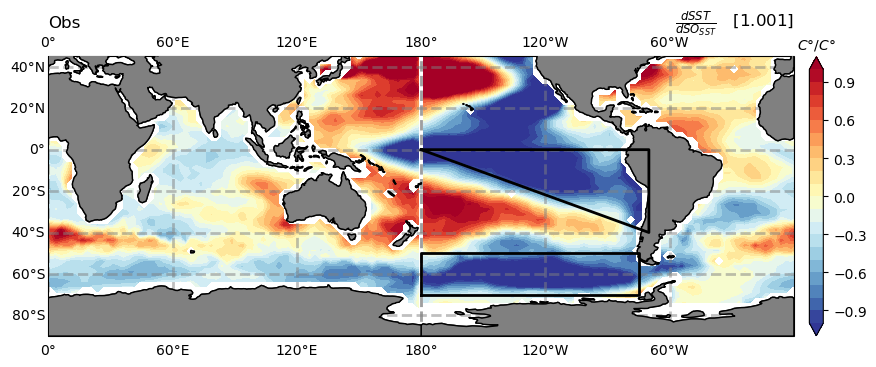

In [149]:
# Calculate the average of all maps
average_map = np.mean([data.squeeze().values for data in obs_sst_maps_reg.values()], axis=0)

# Create a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot the average map
img = _global_plot(
    ax,
    data=-average_map,
    lat=data.latitude,
    lon=data.longitude,
    levels=np.arange(-2, 2.1, .1),
    cmap="RdYlBu_r",
    cbar_label=r"$Wm^{-2}/C\degree$",
)

cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)
ax.set_title(r"$\frac{dSST}{dSO_{SST}}$   " + f"[{np.around(avg_reg, 3)}]", loc="right", fontsize=title_fontsize*.75)
ax.set_title("Obs", loc="left", fontsize=title_fontsize*.75)

plt.show()

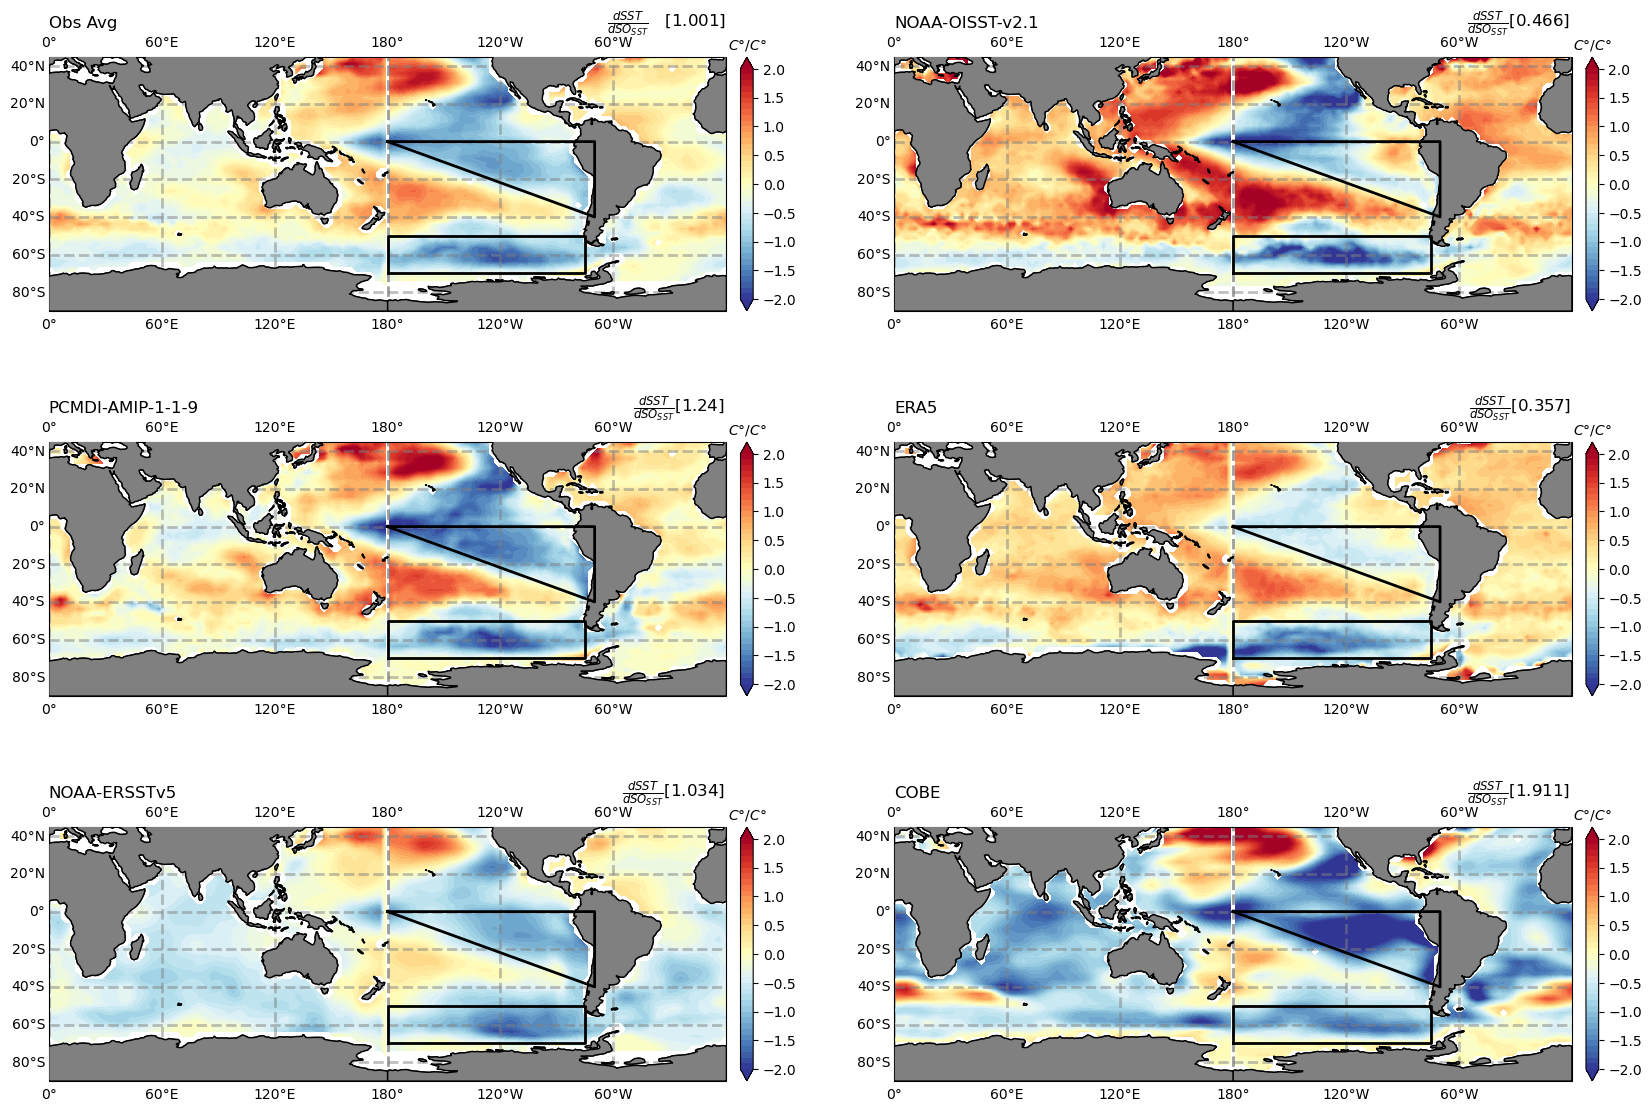

In [152]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# fig.subplots_adjust(right=0.82, hspace=-0.1)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.subplots_adjust(hspace=-0.5)
axis_fontsize = 12
title_fontsize = 16

for i, (ax, (key, data)) in enumerate(zip(axes.flat, obs_sst_maps_reg.items())):
    # Plot spatial map
    if i == 0: 
        # Calculate the average of all maps
        average_map = np.mean([data.squeeze().values for data in obs_sst_maps_reg.values()], axis=0)
        # Plot the average map
        img = _global_plot(
            ax,
            data=-average_map,
            lat=data.latitude,
            lon=data.longitude,
            levels=np.arange(-2, 2.1, .1),
            cmap="RdYlBu_r",
            cbar_label=r"$Wm^{-2}/C\degree$",
        )

        cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
        cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)
        ax.set_title(r"$\frac{dSST}{dSO_{SST}}$   " + f"[{np.around(avg_reg, 3)}]", loc="right", fontsize=title_fontsize*.75)
        ax.set_title("Obs Avg", loc="left", fontsize=title_fontsize*.75)

    ax = axes.flat[i+1]
    img = _global_plot(
        ax,
        data=-data.squeeze().values,
        lat=data.latitude,
        lon=data.longitude,
        levels=np.arange(-2, 2.1, .1),
        cmap="RdYlBu_r",
        cbar_label=r"$Wm^{-2}/C\degree$",
    )
    ax.set_title(r"$\frac{dSST}{dSO_{SST}}$" + f"{np.around(obs_sst_region_reg[key].sel(years=12*5).reg.values, 3)} ", loc="right", fontsize=title_fontsize*.75)
    ax.set_title(key, loc="left", fontsize=title_fontsize*.75)
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)

# cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
# cbar = fig.colorbar(im, cax=cbar_ax, extend="both", orientation='vertical', fraction=.030, pad=0.01)
# cbar.ax.set_title(r"$Wm^{-2}/C\degree$", fontsize=10)

# plt.show()